# Sentimental Analysis in Python


1. Vader (Valence Aware Dictionary and Sentiment Reasoner) - Bag of Words approach
2. Roberta Pretrained LLM Model
3. HuggingFace Pipeline


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

VADER - (Valence Aware Dictionary and Sentiment Reasoner) - Bag of Words approach


It takes all the word in out sentence and have all the values of positive negative or neutral for each of the words and it will add up all the values of words and then will tell what is the score , i.e 1) Positive 2) Negative , 3) Neutral.



# Ploting vader result

# Roberta PreTrained Model
- Use a model trained large corpus of data
- Transformer model accounts for the words but also the context related to the other words
- Vader could not context related words or could not take out correct conclusion if the words are not clear or cannot figure out the context and then analyse
- Takes the context of the sentence too and take out the analysis

In [ ]:
%pip install scipy

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax # applying to the output and will be betn  0 and 1

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# downloads all the weights

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# Vader Results on example
print(example)
sentiAnalsie.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
# Run for Roberta Model
encodedText = tokenizer(example ,  return_tensors = 'pt')
output = model(**encodedText)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores

# negative ,  neutral , positive # scores numpy array after applying softmax

array([0.97635514, 0.02068748, 0.00295737], dtype=float32)

In [ ]:
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

# We can say that the roberta model is more powerful than that of the wader model

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687476, 'roberta_pos': 0.002957372}


In [ ]:
def polarity_scores_roberta(example):
  encodedText = tokenizer(example ,  return_tensors = 'pt')
  output = model(**encodedText)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }

  return scores_dict

In [ ]:
res = {}
for i,row in tqdm(df.iterrows(), total = len(df)):
  try:
    text = row['Text']
    myid = row['Id']
    vader_result =  sentiAnalsie.polarity_scores(text)
    vader_result_rename = {}

    for key, value in vader_result.items():
      vader_result_rename[f"vader_{key}"] = value

    roberta_result =  polarity_scores_roberta(text)
    both = {**vader_result_rename,**roberta_result}
    res[myid] = both
  except RuntimeError:
    print(f'Broke for id {myid}')


  0%|          | 0/1500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1053
Broke for id 1070
Broke for id 1156
Broke for id 1321
Broke for id 1375
Broke for id 1498


In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index':'Id'})
results_df = results_df.merge(df ,how = 'left')

results_df.head(2)
# df['Text'][1]

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [ ]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

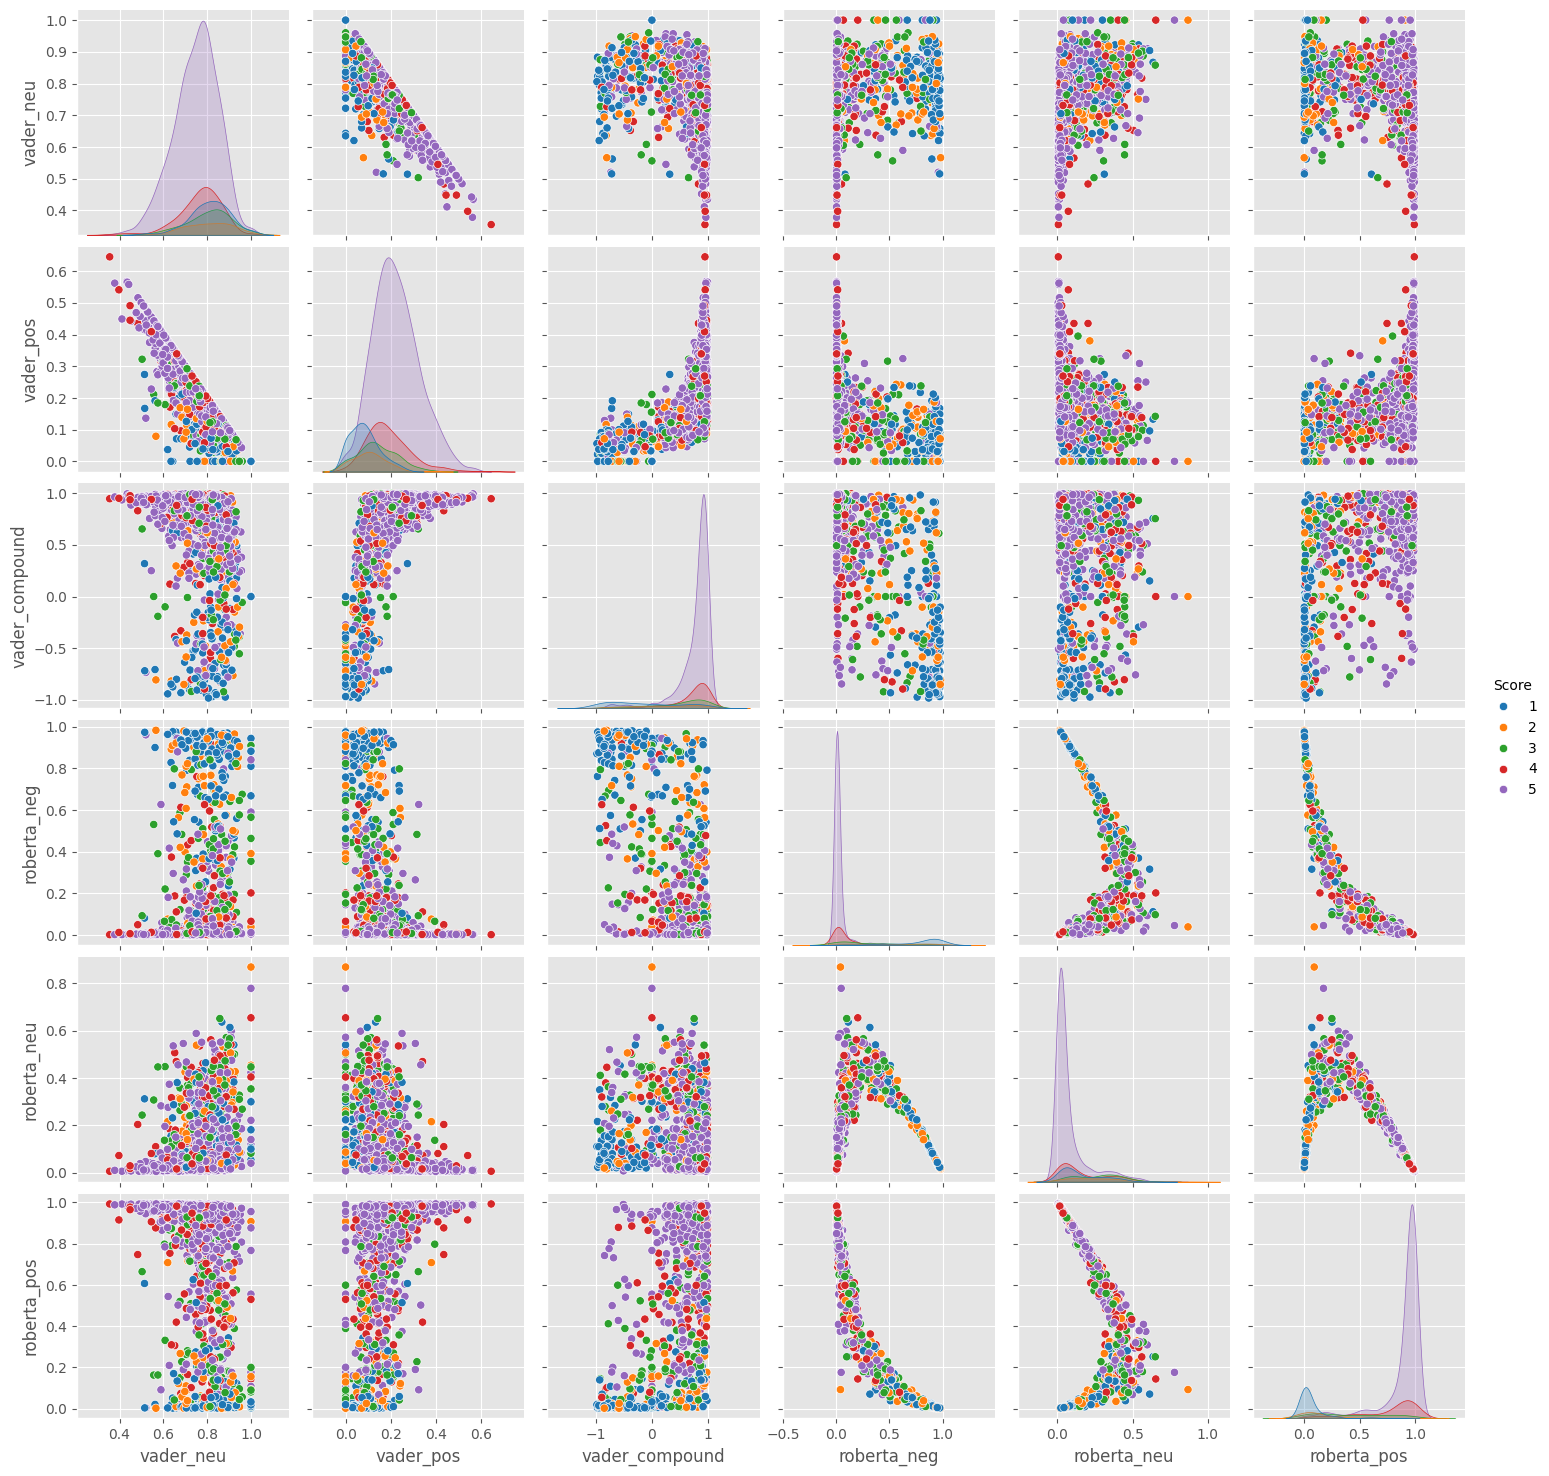

In [ ]:
## Compareing scores between models
sns.pairplot(data = results_df ,
             vars = ['vader_neu','vader_pos','vader_compound',
                    'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue = "Score",
             palette = 'tab10')

plt.show()